The aim is to predict market risk by forecasting financial time series data (e.g.,volatility, Value at Risk (VaR)) and identifying periods of high risk. To achieve this:
Market Risk Prediction: Predict how volatile a market will be...

# Importing Dataset

I tried to create a random dataset using Gaussian Brownian motion. But it did not perform well

LSTM based Data Integration

I took the LSTM method to create synthetic data.. This method looks for the long term dependencies and generate synthetic data

In [157]:
#pip install sktime

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

# Prepare the data
data = stock_data['close'].values.reshape(-1, 1)
X, y = [], []
for i in range(len(data) - 10):
    X.append(data[i:i+10])
    y.append(data[i+10])
X, y = np.array(X), np.array(y)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20)

# Generate synthetic data
last_sequence = X[-1]
synthetic_close = []
for _ in range(100):
    next_value = model.predict(last_sequence.reshape(1, -1, 1))
    synthetic_close.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[1:], next_value)

synthetic_data = pd.DataFrame({
    'timestamp': pd.date_range(start='2024-10-12', periods=100),
    'close': synthetic_close
})
print(synthetic_data.head())

NameError: name 'stock_data' is not defined

This method doesnot give the data with similar statistical properties and soes not continue the sequence value instead creating synthetic values as continuation from first. so i drop this method

I get the Data with the help of Alpha Vantage API

In [4]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [5]:
def fetch_data(symbol, api_key):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&interval=60min&outputsize=full&datatype=csv'
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

In [6]:
symbol = 'AAPL'
api_key = 'ZJ0088EP7QMAZIJT'

stock_data = fetch_data(symbol, api_key)
stock_data

,timestamp,open,high,low,close,volume
0,2024-11-14,225.02,228.87,225.000,228.22,44923941
1,2024-11-13,224.01,226.65,222.760,225.12,48566217
2,2024-11-12,224.55,225.59,223.355,224.23,40398299
3,2024-11-11,225.00,225.70,221.500,224.23,42005602
4,2024-11-08,227.17,228.66,226.405,226.96,38328824
...,...,...,...,...,...,...
6296,1999-11-05,84.62,88.37,84.000,88.31,3721500
6297,1999-11-04,82.06,85.37,80.620,83.62,3384700
6298,1999-11-03,81.62,83.25,81.000,81.50,2932700
6299,1999-11-02,78.00,81.69,77.310,80.25,3564600


Time GAN for Synthetic Data Generation

In [161]:
#pip install ydata-synthetic

In [162]:
#pip install --upgrade ydata-sdk

In [164]:
#I changed the generators output form tanh function to sigmoid function to avoid negative values

In [7]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
dataset = stock_data
# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset[['open', 'high', 'low', 'close', 'volume']])

# Prepare sequences for TimeGAN
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

SEQ_LENGTH = 10
sequences = create_sequences(scaled_data, SEQ_LENGTH)

# Define the TimeGAN architecture
class TimeGAN:
    def __init__(self, seq_length, num_features):
        self.seq_length = seq_length
        self.num_features = num_features
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.supervisor = self.build_supervisor()

    def build_generator(self):
        model = keras.Sequential()
        model.add(layers.LSTM(64, return_sequences=True, input_shape=(self.seq_length, self.num_features)))
        model.add(layers.LSTM(128, return_sequences=True))
        model.add(layers.Dense(self.num_features, activation='sigmoid'))
        return model

    def build_discriminator(self):
        model = keras.Sequential()
        model.add(layers.LSTM(64, return_sequences=True, input_shape=(self.seq_length, self.num_features)))
        model.add(layers.LSTM(32))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def build_supervisor(self):
        model = keras.Sequential()
        model.add(layers.LSTM(64, return_sequences=True, input_shape=(self.seq_length, self.num_features)))
        model.add(layers.LSTM(32))
        model.add(layers.Dense(self.num_features, activation='tanh'))
        return model

    def compile_models(self):
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.supervisor.compile(optimizer='adam', loss='mean_squared_error')

    def train(self, real_data, epochs, batch_size):
        for epoch in range(epochs):
            # Generate synthetic data
            noise = np.random.normal(0, 1, (batch_size, self.seq_length, self.num_features))
            synthetic_data = self.generator.predict(noise)

            # Train discriminator
            X = np.concatenate([real_data, synthetic_data])
            y = np.array([1] * real_data.shape[0] + [0] * synthetic_data.shape[0])
            self.discriminator.train_on_batch(X, y)

            # Train supervisor
            supervisor_data = self.supervisor.predict(synthetic_data)
            self.supervisor.train_on_batch(synthetic_data, supervisor_data)

# Initialize and compile TimeGAN
time_gan = TimeGAN(SEQ_LENGTH, scaled_data.shape[1])
time_gan.compile_models()

# Train the model
EPOCHS = 50
BATCH_SIZE = 256
time_gan.train(sequences, EPOCHS, BATCH_SIZE)

# Generate synthetic data
num_synthetic_samples = 4000
noise = np.random.normal(0, 1, (num_synthetic_samples, SEQ_LENGTH, scaled_data.shape[1]))
synthetic_data = time_gan.generator.predict(noise)

# Inverse transform the synthetic data
synthetic_data = scaler.inverse_transform(synthetic_data.reshape(-1, scaled_data.shape[1]))

# Flatten the synthetic data and ensure each sequence is 10 steps
synthetic_data_sequences = synthetic_data.reshape(num_synthetic_samples, SEQ_LENGTH, scaled_data.shape[1])

# Take the last time step from each sequence (for plotting/analysis purposes)
final_data = synthetic_data_sequences[:, -1, :]

# Create a DataFrame with timestamps for these 1,000 points
synthetic_df = pd.DataFrame(final_data, columns=['open', 'high', 'low', 'close', 'volume'])
synthetic_df['timestamp'] = pd.date_range(start='2024-10-12', periods=num_synthetic_samples)
synthetic_df = synthetic_df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━

In [166]:
print(synthetic_df)

      timestamp        open        high         low       close       volume
0    2024-10-12  362.371246  360.546082  351.277679  350.478516  161411856.0
1    2024-10-13  363.427643  362.679382  350.700439  349.720825  168794720.0
2    2024-10-14  360.318390  359.529938  357.500366  357.607727  165713920.0
3    2024-10-15  360.563629  362.941681  361.350616  361.786774  159015328.0
4    2024-10-16  356.052826  355.322968  367.500427  355.512848  166718256.0
...         ...         ...         ...         ...         ...          ...
3995 2035-09-20  359.911774  367.680420  355.080750  354.567444  163907104.0
3996 2035-09-21  353.087646  350.005188  362.730896  349.428558  167629504.0
3997 2035-09-22  365.605225  358.381012  350.226349  362.308044  165995616.0
3998 2035-09-23  357.255341  361.320007  359.416199  360.436951  164762496.0
3999 2035-09-24  356.641235  356.821198  357.735413  346.695526  166078336.0

[4000 rows x 6 columns]


In [8]:
print(synthetic_df)

      timestamp        open        high         low       close       volume
0    2024-10-12  360.931763  365.669495  344.416809  353.790436  171405152.0
1    2024-10-13  357.125763  358.556824  359.261719  354.349915  163201888.0
2    2024-10-14  362.750122  358.985931  366.764771  361.083649  162884976.0
3    2024-10-15  354.671814  362.614014  356.030914  355.647278  164995248.0
4    2024-10-16  357.899384  358.921722  357.562653  362.426697  167102048.0
...         ...         ...         ...         ...         ...          ...
3995 2035-09-20  366.713776  359.701660  355.555878  358.251465  165905776.0
3996 2035-09-21  366.906281  364.257172  350.042908  351.321808  167522992.0
3997 2035-09-22  351.306915  360.739990  358.764069  359.361084  165429472.0
3998 2035-09-23  360.279388  355.876343  362.825989  364.933441  164503664.0
3999 2035-09-24  351.080994  364.234863  350.942261  353.163910  165895328.0

[4000 rows x 6 columns]


In [167]:
%store synthetic_df

Stored 'synthetic_df' (DataFrame)


In [168]:
#print(sequences)

In [169]:
len(sequences)    #sequence with 10 time steps

6267

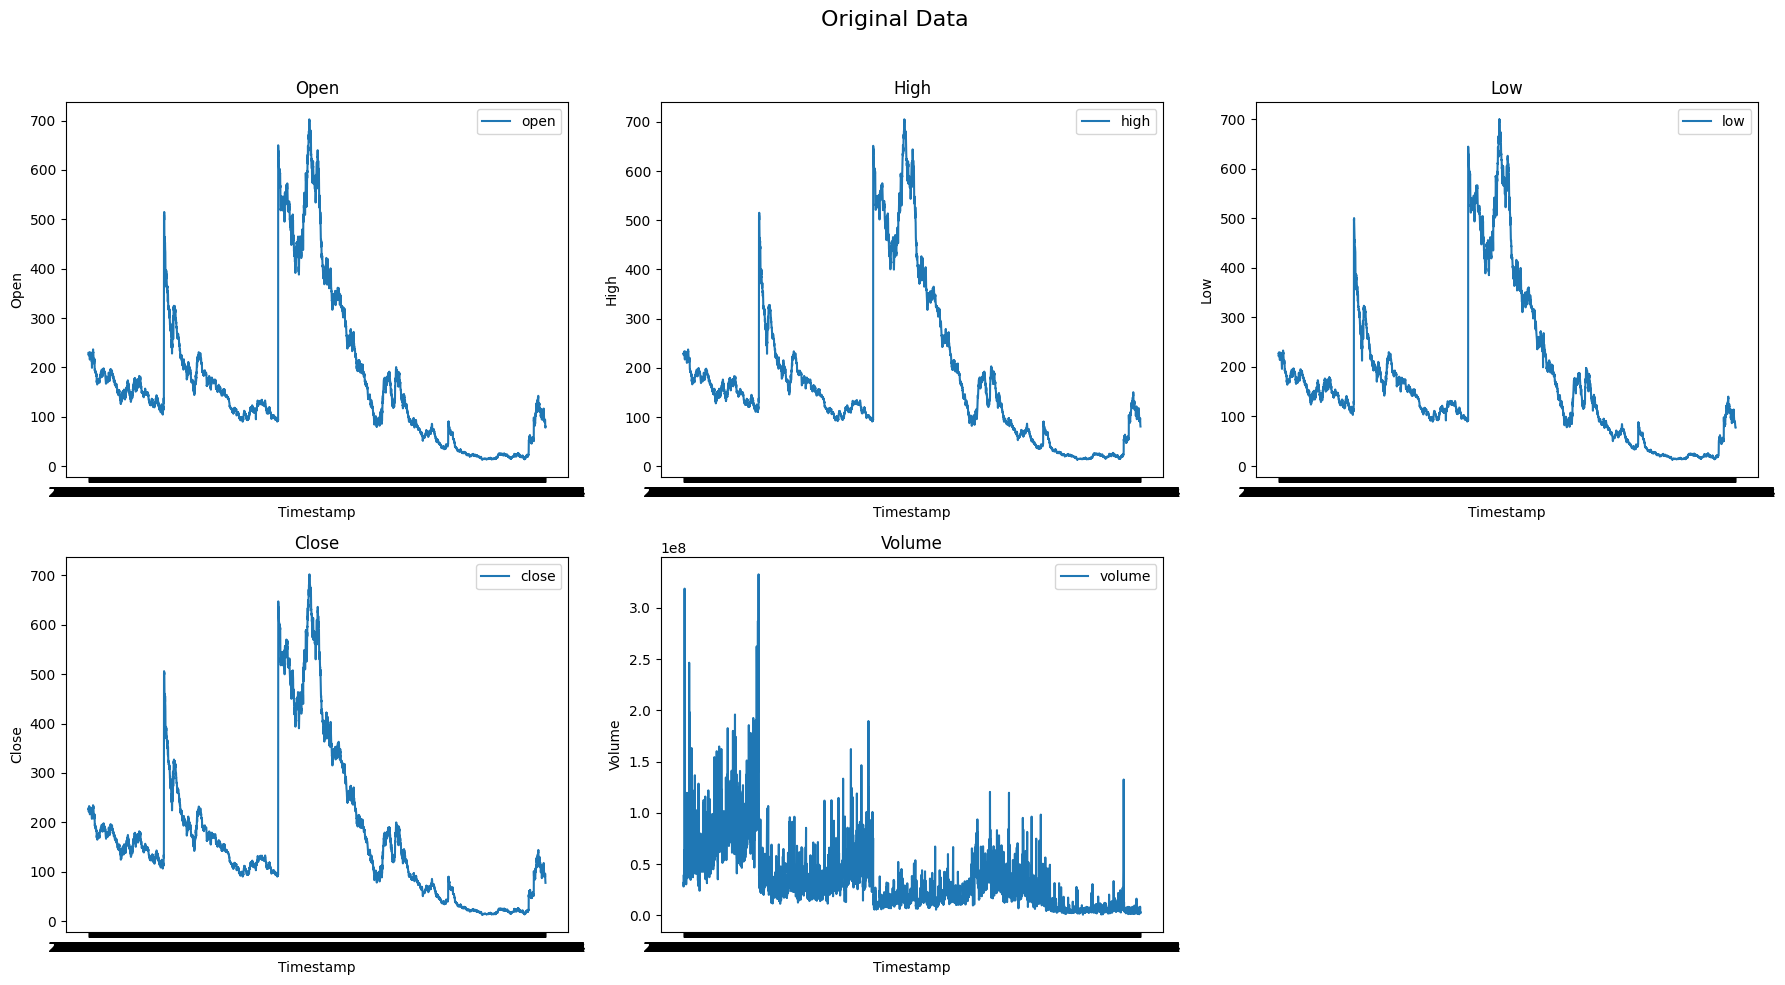

In [320]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Original Data', fontsize=16)

features = ['open', 'high', 'low', 'close', 'volume']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)  # Calculate row and column index
    axes[row, col].plot(stock_data['timestamp'], stock_data[feature], label=feature, color='tab:blue')
    axes[row, col].set_title(f'{feature.capitalize()}')
    axes[row, col].set_xlabel('Timestamp')
    axes[row, col].set_ylabel(feature.capitalize())
    axes[row, col].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  
# Hide the last unused subplot (if any)
axes[1, 2].axis('off')
plt.show()

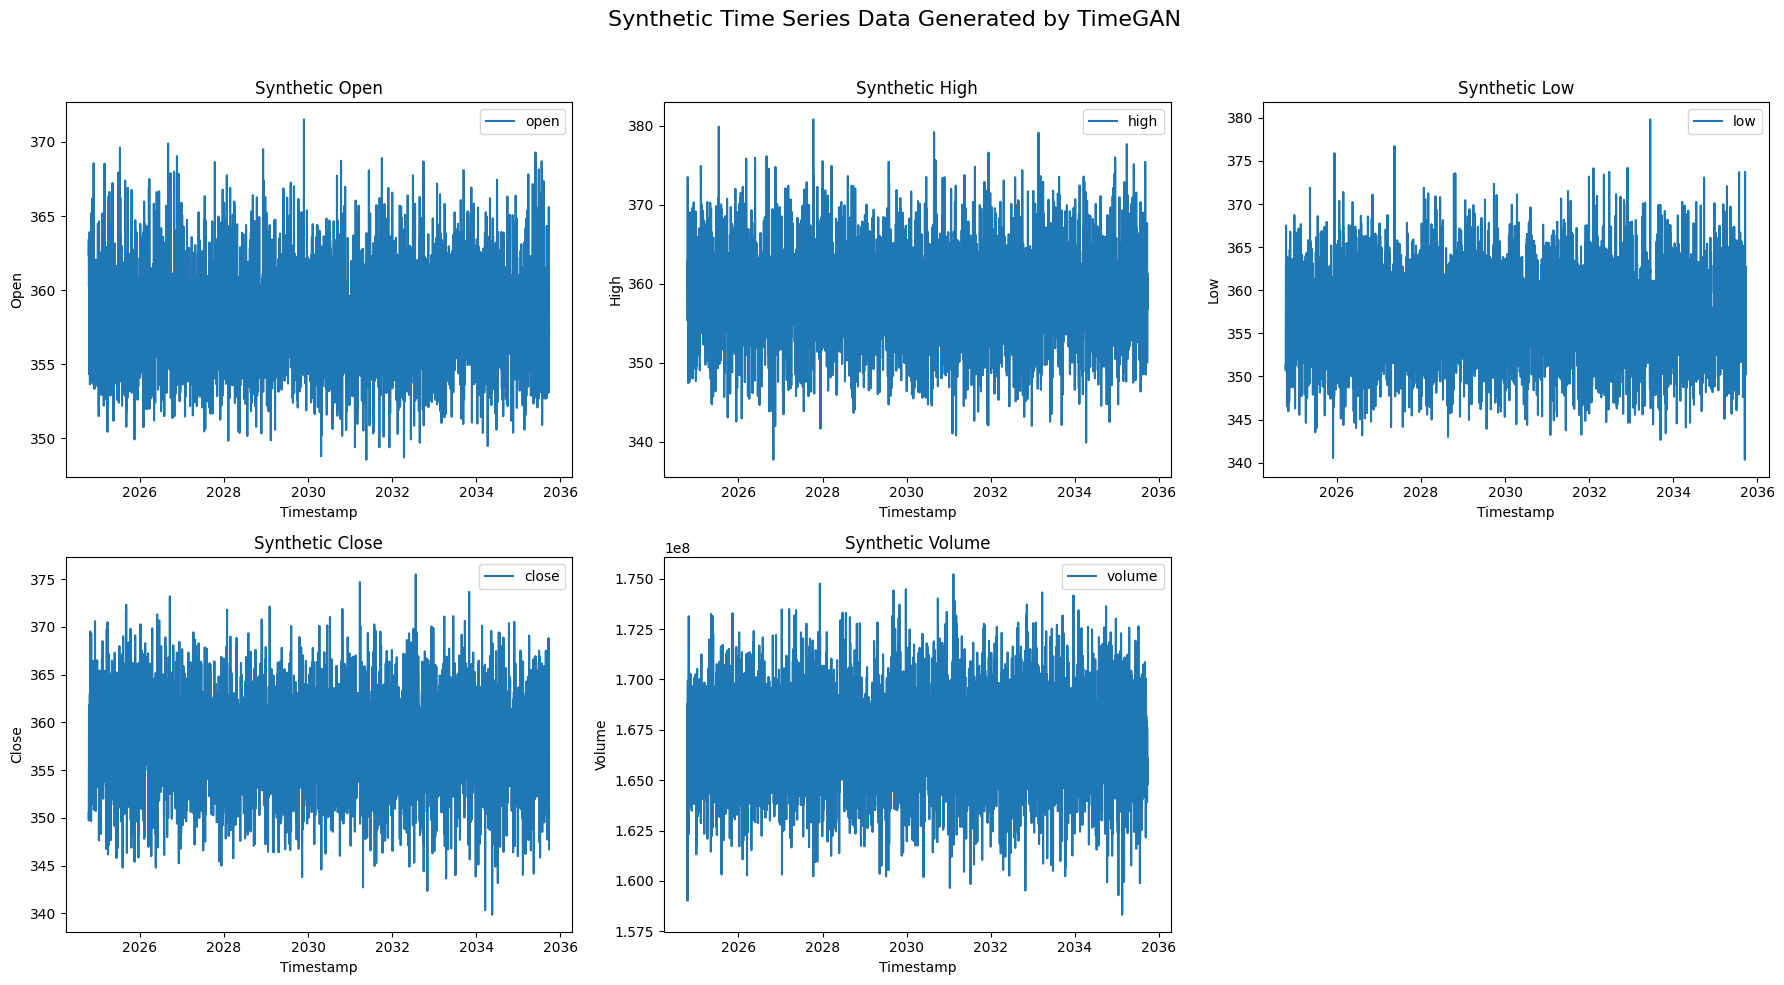

In [171]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Synthetic Time Series Data Generated by TimeGAN', fontsize=16)

features = ['open', 'high', 'low', 'close', 'volume']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)  # Calculate row and column index
    axes[row, col].plot(synthetic_df['timestamp'], synthetic_df[feature], label=feature, color='tab:blue')
    axes[row, col].set_title(f'Synthetic {feature.capitalize()}')
    axes[row, col].set_xlabel('Timestamp')
    axes[row, col].set_ylabel(feature.capitalize())
    axes[row, col].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  
# Hide the last unused subplot (if any)
axes[1, 2].axis('off')
plt.show()

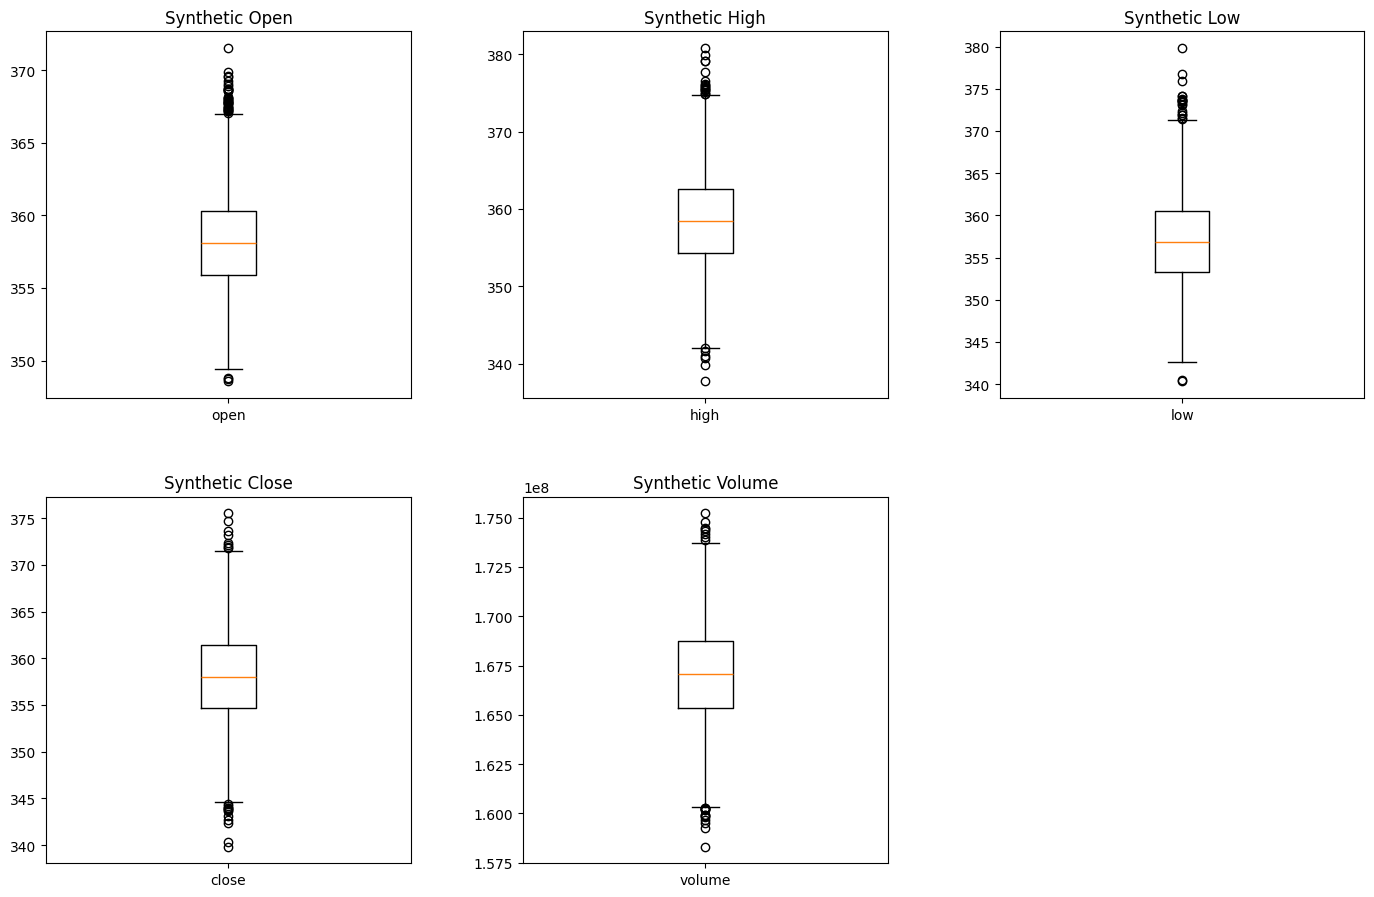

In [352]:

features = ['open', 'high', 'low', 'close', 'volume']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=5.0)  # Adjust padding

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    row, col = divmod(i, 3)  # Calculate row and column index
    axes[row, col].boxplot(synthetic_df[feature], labels=[feature])
    axes[row, col].set_title(f'Synthetic {feature.capitalize()}')

# Remove any empty subplot if features are fewer than subplots
for j in range(i + 1, 6):
    fig.delaxes(axes[j // 3, j % 3])

plt.show()

Leave the data as it is because removing outliers cause statistical properties of the data to collapse. Sometimes the price go sudden up and down, we should have consider this in the input data

In [172]:
data = synthetic_df

In [173]:
%store data

Stored 'data' (DataFrame)


In [331]:
%store -r data
print(data)

      timestamp        open        high         low       close       volume
0    2024-10-12  362.371246  360.546082  351.277679  350.478516  161411856.0
1    2024-10-13  363.427643  362.679382  350.700439  349.720825  168794720.0
2    2024-10-14  360.318390  359.529938  357.500366  357.607727  165713920.0
3    2024-10-15  360.563629  362.941681  361.350616  361.786774  159015328.0
4    2024-10-16  356.052826  355.322968  367.500427  355.512848  166718256.0
...         ...         ...         ...         ...         ...          ...
3995 2035-09-20  359.911774  367.680420  355.080750  354.567444  163907104.0
3996 2035-09-21  353.087646  350.005188  362.730896  349.428558  167629504.0
3997 2035-09-22  365.605225  358.381012  350.226349  362.308044  165995616.0
3998 2035-09-23  357.255341  361.320007  359.416199  360.436951  164762496.0
3999 2035-09-24  356.641235  356.821198  357.735413  346.695526  166078336.0

[4000 rows x 6 columns]


In [174]:
data.shape

(4000, 6)

In [175]:
data.describe()

,timestamp,open,high,low,close,volume
count,4000,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03
mean,2030-04-03 12:00:00,358.199066,358.524506,356.978210,358.012726,1.670453e+08
min,2024-10-12 00:00:00,348.567200,337.726196,340.338013,339.847595,1.583198e+08
25%,2027-07-08 18:00:00,355.882706,354.336113,353.335602,354.625542,1.653596e+08
50%,2030-04-03 12:00:00,358.093994,358.521042,356.821472,358.002945,1.670539e+08
75%,2032-12-28 06:00:00,360.338646,362.550117,360.533386,361.445549,1.687292e+08
max,2035-09-24 00:00:00,371.525543,380.811951,379.819855,375.517029,1.752213e+08
std,NaN,3.359650,6.017931,5.289523,5.001495,2.477291e+06


In [176]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4000 non-null   datetime64[ns]
 1   open       4000 non-null   float32       
 2   high       4000 non-null   float32       
 3   low        4000 non-null   float32       
 4   close      4000 non-null   float32       
 5   volume     4000 non-null   float32       
dtypes: datetime64[ns](1), float32(5)
memory usage: 109.5 KB


In [177]:
data.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

In [178]:
data.nunique()

timestamp    4000
open         3974
high         3974
low          3970
close        3981
volume       3978
dtype: int64

In [179]:
data.duplicated().sum()

0

In [180]:
data.corr()

,timestamp,open,high,low,close,volume
timestamp,1.000000,0.004983,0.021190,-0.005103,-0.008547,-0.003316
open,0.004983,1.000000,0.549210,-0.599857,0.088312,-0.405183
high,0.021190,0.549210,1.000000,-0.330482,-0.165137,-0.190638
low,-0.005103,-0.599857,-0.330482,1.000000,0.045087,0.186763
close,-0.008547,0.088312,-0.165137,0.045087,1.000000,-0.006571
volume,-0.003316,-0.405183,-0.190638,0.186763,-0.006571,1.000000


Text(0.5, 1.0, 'Heat Map for the Synthetic data')

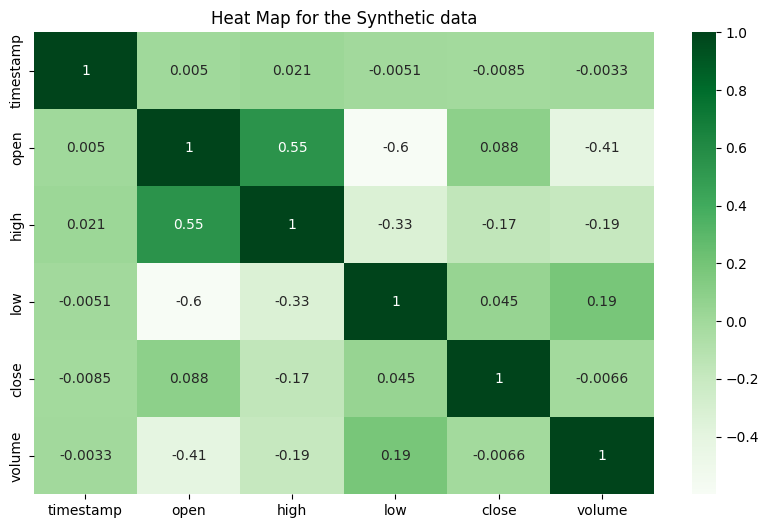

In [181]:
fig, axes = plt.subplots(figsize = (10,6))
sns.heatmap(data.corr(), annot = True, cmap='Greens')       #annot is to display the values inside the box
plt.title('Heat Map for the Synthetic data')


In [332]:
# Calculate daily returns as a percentage change in the closing price
data['returns'] = data['close'].pct_change()

In [333]:
# Compute rolling volatility (e.g., 5-day standard deviation of returns)
data['volatility'] = data['returns'].rolling(window=5).std()

In [334]:
# Calculate Value at Risk (VaR) at 95% confidence level
confidence_level = 0.05
data['VaR_95'] = data['returns'].rolling(window=5).quantile(confidence_level)

In [335]:
# Drop NaN values
data.dropna(inplace=True)
print(data[['timestamp', 'close','returns', 'volatility', 'VaR_95']])

      timestamp       close   returns  volatility    VaR_95
5    2024-10-17  356.435181  0.002594    0.014977 -0.014306
6    2024-10-18  360.053650  0.010152    0.014832 -0.013354
7    2024-10-19  352.983032 -0.019638    0.015010 -0.019178
8    2024-10-20  359.159058  0.017497    0.016532 -0.019178
9    2024-10-21  353.913910 -0.014604    0.015903 -0.018631
...         ...         ...       ...         ...       ...
3995 2035-09-20  354.567444 -0.038677    0.021128 -0.032007
3996 2035-09-21  349.428558 -0.014493    0.021321 -0.033840
3997 2035-09-22  362.308044  0.036859    0.029116 -0.033840
3998 2035-09-23  360.436951 -0.005164    0.029122 -0.033840
3999 2035-09-24  346.695526 -0.038124    0.030961 -0.038566

[3995 rows x 5 columns]


In [336]:
print(data)

      timestamp        open        high         low       close       volume  \
5    2024-10-17  362.856628  373.512817  354.927704  356.435181  164868320.0   
6    2024-10-18  355.808716  359.118835  354.232117  360.053650  169939424.0   
7    2024-10-19  354.315247  362.819153  363.505035  352.983032  167619408.0   
8    2024-10-20  363.921265  362.868500  352.579590  359.159058  163763712.0   
9    2024-10-21  355.189850  356.698364  362.274017  353.913910  168695808.0   
...         ...         ...         ...         ...         ...          ...   
3995 2035-09-20  359.911774  367.680420  355.080750  354.567444  163907104.0   
3996 2035-09-21  353.087646  350.005188  362.730896  349.428558  167629504.0   
3997 2035-09-22  365.605225  358.381012  350.226349  362.308044  165995616.0   
3998 2035-09-23  357.255341  361.320007  359.416199  360.436951  164762496.0   
3999 2035-09-24  356.641235  356.821198  357.735413  346.695526  166078336.0   

       returns  volatility    VaR_95  


In [338]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume','returns', 'volatility', 'VaR_95']])

In [188]:
print(scaled_data)

[[0.62240678 0.83059057 0.36952914 ... 0.52924437 0.28799881 0.75400397]
 [0.3154198  0.49651305 0.35191124 ... 0.58621049 0.28498817 0.76818713]
 [0.25036854 0.58239566 0.58677664 ... 0.36166619 0.28869232 0.6813484 ]
 ...
 [0.7421278  0.47938851 0.25045276 ... 0.78751799 0.58150669 0.46274022]
 [0.37843065 0.54760121 0.48321418 ... 0.47076147 0.58161727 0.46274022]
 [0.35168198 0.44318596 0.44064307 ... 0.22231992 0.61978891 0.39227213]]


In [189]:
scaled_data.shape

(3995, 8)

In [339]:
df_data = pd.DataFrame(scaled_data, columns = ['open', 'high', 'low', 'close', 'volume','returns', 'volatility', 'VaR_95'])
df_data

,open,high,low,close,volume,returns,volatility,VaR_95
0,0.622407,0.830591,0.369529,0.465036,0.387451,0.529244,0.287999,0.754004
1,0.315420,0.496513,0.351911,0.566481,0.687490,0.586210,0.284988,0.768187
2,0.250369,0.582396,0.586777,0.368255,0.550223,0.361666,0.288692,0.681348
3,0.668779,0.583541,0.310056,0.541401,0.322095,0.641574,0.320278,0.681348
4,0.288464,0.440335,0.555597,0.394352,0.613910,0.399609,0.307226,0.689512
...,...,...,...,...,...,...,...,...
3990,0.494137,0.695223,0.373405,0.412674,0.330579,0.218155,0.415683,0.490068
3991,0.196898,0.284990,0.567169,0.268604,0.550821,0.400442,0.419689,0.462740
3992,0.742128,0.479389,0.250453,0.629683,0.454149,0.787518,0.581507,0.462740
3993,0.378431,0.547601,0.483214,0.577227,0.381190,0.470761,0.581617,0.462740


In [340]:
print(len(df_data))

3995


In [192]:
# #creating sequence for predicting model
# def create_seq(data, time_steps, target_var):
#     x, y = [],[]
#     for i in range(len(data)-time_steps):
#         x.append(data.iloc[i:i+time_steps][['open', 'high', 'low', 'close', 'volume']].values)
#         y.append(data.iloc[i+time_steps][target_var])
#         return np.array(x),np.array(y)

In [193]:
# x, y = create_seq(data, time_steps = 10, target_var = 'volatility')
# print(x)
# print(y)

In [194]:
# print(x.shape)
# print(y.shape)

In [195]:
# If not changed to dataframe (Handling with numpy array

def create_sequences(data, time_steps, target_index):
    x, y,y1 = [], [],  []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps, :])  # Use slicing for NumPy arrays
        y.append(data[i + time_steps, target_index])  # Target value from the given index
        y1.append(data[i + time_steps, target_index+1])
    return np.array(x), np.array(y), np.array(y1)

# Generate sequences using NumPy arrays
x, y, y1 = create_sequences(scaled_data, time_steps=10, target_index=6)  # volatality at inde 6 and VaR at index 7

print(x)
print(y)
print(y1)

[[[0.62240678 0.83059057 0.36952914 ... 0.52924437 0.28799881 0.75400397]
  [0.3154198  0.49651305 0.35191124 ... 0.58621049 0.28498817 0.76818713]
  [0.25036854 0.58239566 0.58677664 ... 0.36166619 0.28869232 0.6813484 ]
  ...
  [0.48946895 0.38000714 0.15668669 ... 0.46202655 0.37058632 0.74218976]
  [0.61132342 0.50508204 0.30168403 ... 0.81425829 0.50583202 0.74218976]
  [0.4283483  0.54523265 0.59552182 ... 0.24453641 0.61525535 0.50231679]]

 [[0.3154198  0.49651305 0.35191124 ... 0.58621049 0.28498817 0.76818713]
  [0.25036854 0.58239566 0.58677664 ... 0.36166619 0.28869232 0.6813484 ]
  [0.6687793  0.58354098 0.31005588 ... 0.64157358 0.32027803 0.6813484 ]
  ...
  [0.61132342 0.50508204 0.30168403 ... 0.81425829 0.50583202 0.74218976]
  [0.4283483  0.54523265 0.59552182 ... 0.24453641 0.61525535 0.50231679]
  [0.56814511 0.57805167 0.43747242 ... 0.37116533 0.56778073 0.49290531]]

 [[0.25036854 0.58239566 0.58677664 ... 0.36166619 0.28869232 0.6813484 ]
  [0.6687793  0.583540

In [196]:
print("x shape:", x.shape)
print("y shape:", y.shape)
print("y1 shape:", y1.shape)

x shape: (3985, 10, 8)
y shape: (3985,)
y1 shape: (3985,)


In [197]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,train_size = 0.8, test_size = 0.2, random_state=42)

In [198]:
x_train, x_test, y1_train, y1_test = train_test_split(x, y1,train_size = 0.8, test_size = 0.2, random_state=42)

In [199]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(3188, 10, 8)
(3188,)
(797, 10, 8)
(797,)
(3188,)
(797,)


# Model Building

In [ ]:
#pip install hyperopt

In [238]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

# Data preparation (assuming you have X_train, y_train, X_test, y_test ready)
# Ensure your data is scaled (e.g., MinMaxScaler or StandardScaler applied)

# Define the CNN + LSTM model as a function
def create_model(params):
    model = Sequential()
    
    # CNN Layer
    model.add(Conv1D(filters=int(params['filters']), kernel_size=params['kernel_size'], 
                     activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(params['dropout_cnn']))
    
    # LSTM Layers
    model.add(LSTM(units=int(params['lstm_units']), return_sequences=True))
    model.add(Dropout(params['dropout_lstm']))
    model.add(LSTM(units=int(params['lstm_units']), return_sequences=False))
    model.add(Dropout(params['dropout_lstm']))
    
    # Output Layer
    model.add(Dense(1))  # Predicting a continuous value
    
    # Compile the model
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error')
    
    return model

# Define the objective function for HyperOpt
def objective(params):
    print(f"Training with params: {params}")
    model = create_model(params)
    
    history = model.fit(x_train, y_train, epochs=int(params['epochs']), 
                        batch_size=int(params['batch_size']), 
                        validation_data=(x_test, y_test), verbose=0)
    
    # Predict and calculate the RMSE
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")
    
    return {'loss': rmse, 'status': STATUS_OK}

# Define the search space for HyperOpt
search_space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 16)),  # 32 to 128 in steps of 16
    'kernel_size': hp.choice('kernel_size', [2, 3, 5]),
    'dropout_cnn': hp.uniform('dropout_cnn', 0.1, 0.5),
    'lstm_units': scope.int(hp.quniform('lstm_units', 32, 128, 16)),
    'dropout_lstm': hp.uniform('dropout_lstm', 0.1, 0.5),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 10, 50, 10)),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop']),
}

# Initialize trials to keep track of the search process
trials = Trials()

# Run the HyperOpt search
best = fmin(fn=objective, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=20, 
            trials=trials)



Training with params: {'batch_size': 64, 'dropout_cnn': 0.3201222648135674, 'dropout_lstm': 0.4950957331998649, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'lstm_units': 48, 'optimizer': 'adam'}
 1/25 ━━━━━━━━━━━━━━━━━━━━ 14s 616ms/step                                                     
 5/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                              
11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                              
18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                               
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                             
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step                                              

RMSE: 0.0723287932307508                                                                                               
Training with params: {'batch_size': 48, 'dropout_cnn': 0.4811751231796575, 'dropout_lstm': 0.39863811561882523, 'epochs': 50, 'filters': 112, 'kernel_size':

In [239]:
print(f"Best hyperparameters: {best}")

Best hyperparameters: {'batch_size': 48.0, 'dropout_cnn': 0.4855750262413704, 'dropout_lstm': 0.4973987754445949, 'epochs': 50.0, 'filters': 96.0, 'kernel_size': 2, 'lstm_units': 32.0, 'optimizer': 0}


In [279]:
def CNN_LSTM_model():
    model = keras.Sequential()
    model.add(layers.Conv1D(filters = 96, kernel_size = 2,activation = 'relu', input_shape = (x_train.shape[1],x_train.shape[2])))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Dropout(0.48))

    model.add(layers.LSTM(units = 32, return_sequences=True))
    model.add(layers.LSTM(units = 32, return_sequences= False))
    model.add(layers.Dropout(0.49))

    model.add(layers.Dense(units = 1))                    #no actvation function because we are predicting continuous value
    
    return model
  

In [307]:
hybrid_model = CNN_LSTM_model()

hybrid_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

In [308]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
hybrid_model.fit(x_train, y_train, batch_size = 48, epochs= 50, validation_data = (x_test, y_test))

In [306]:
def CNN_LSTM_model():
    model = keras.Sequential()
    model.add(layers.Conv1D(filters = 64, kernel_size = 3,activation = 'relu', input_shape = (x_train.shape[1],x_train.shape[2])))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Dropout(0.2))

    model.add(layers.LSTM(units = 100, return_sequences=True))
    model.add(layers.LSTM(units = 100, return_sequences= False))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(units = 1))                    #no actvation function because we are predicting continuous value
    
    return model
    

In [307]:
hybrid_model = CNN_LSTM_model()

hybrid_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

In [308]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [309]:
hybrid_model.fit(x_train, y_train, batch_size = 32, epochs= 50, validation_data = (x_test, y_test))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms

In [310]:
# Make predictions
y_pred = hybrid_model.predict(x_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [311]:
print(y_pred)

[[0.37460923]
 [0.28506047]
 [0.543372  ]
 [0.1918285 ]
 [0.33856434]
 [0.48939067]
 [0.26435658]
 [0.29901206]
 [0.32804725]
 [0.29603198]
 [0.36096993]
 [0.15157565]
 [0.37753105]
 [0.38382858]
 [0.6938349 ]
 [0.25543296]
 [0.490509  ]
 [0.36385635]
 [0.25742316]
 [0.45145702]
 [0.27092457]
 [0.43324926]
 [0.27977517]
 [0.4877711 ]
 [0.6149907 ]
 [0.45245224]
 [0.57911503]
 [0.21495104]
 [0.39628845]
 [0.35900903]
 [0.3016836 ]
 [0.24382772]
 [0.43962234]
 [0.30268782]
 [0.30732366]
 [0.25449124]
 [0.34651154]
 [0.60389626]
 [0.351837  ]
 [0.32775295]
 [0.45845503]
 [0.30685067]
 [0.32635278]
 [0.6351633 ]
 [0.5927104 ]
 [0.2323819 ]
 [0.2685262 ]
 [0.3756574 ]
 [0.24592777]
 [0.42411518]
 [0.37950754]
 [0.42331618]
 [0.62017727]
 [0.43099254]
 [0.6501047 ]
 [0.43897292]
 [0.25013497]
 [0.35801357]
 [0.42975122]
 [0.20641202]
 [0.27400807]
 [0.38962752]
 [0.64143145]
 [0.47597143]
 [0.23347856]
 [0.50586843]
 [0.37502062]
 [0.15965855]
 [0.34552473]
 [0.26493683]
 [0.57163346]
 [0.74

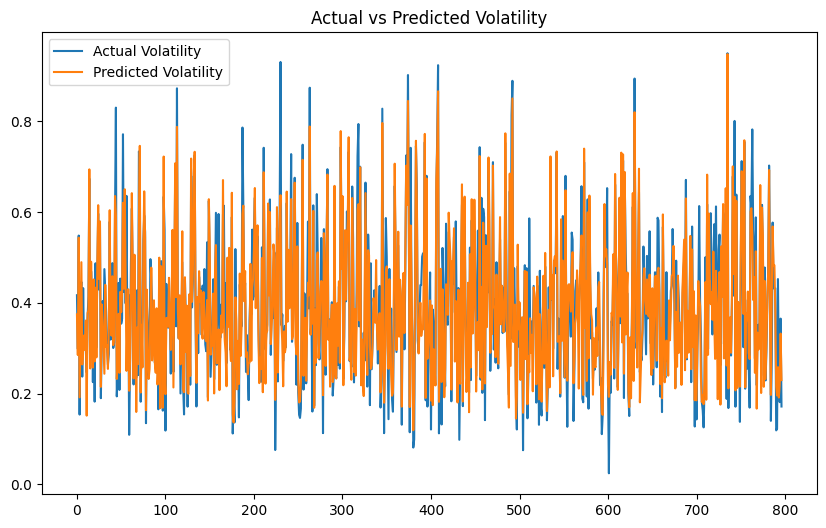

In [312]:
# Plot Actual vs Predicted Volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Volatility')
plt.plot(y_pred, label='Predicted Volatility')
plt.title('Actual vs Predicted Volatility')
plt.legend()
plt.show()

In [313]:
# Calculate Mean Squared Error (MSE) for model evaluation
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.004766700473116662


In [287]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


R² Score: 0.5659056231940152


In [269]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.07776353234708808


In [270]:
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.1085655168576307


In [271]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape * 100}%")


Mean Absolute Percentage Error: 26.00652121013434%


In [314]:
accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.1) * 100
print(f"Accuracy: {accuracy}%")

Accuracy: 13.418575618418505%


In [315]:
hybrid_model.fit(x_train, y1_train, batch_size = 32, epochs= 50, validation_data = (x_test, y1_test))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/

In [316]:
y1_pred = hybrid_model.predict(x_test)
print(y1_pred)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[0.7407454 ]
 [0.7414579 ]
 [0.4894253 ]
 [0.7857587 ]
 [0.6111683 ]
 [0.5230392 ]
 [0.6502811 ]
 [0.69659317]
 [0.56996167]
 [0.59950745]
 [0.7694443 ]
 [0.79754424]
 [0.5669393 ]
 [0.5542905 ]
 [0.55414146]
 [0.71024704]
 [0.5137619 ]
 [0.6580514 ]
 [0.765535  ]
 [0.600236  ]
 [0.7033324 ]
 [0.6575812 ]
 [0.73278576]
 [0.58018243]
 [0.37734365]
 [0.57308894]
 [0.555324  ]
 [0.81033844]
 [0.70479697]
 [0.6367657 ]
 [0.6833308 ]
 [0.7235513 ]
 [0.7501312 ]
 [0.7508384 ]
 [0.6790758 ]
 [0.754897  ]
 [0.71620524]
 [0.6089293 ]
 [0.78377545]
 [0.69642335]
 [0.6659009 ]
 [0.65209514]
 [0.66735095]
 [0.44025463]
 [0.57503825]
 [0.7461928 ]
 [0.6574894 ]
 [0.6110275 ]
 [0.7450981 ]
 [0.6208172 ]
 [0.6285578 ]
 [0.7043748 ]
 [0.56877375]
 [0.66116834]
 [0.3118948 ]
 [0.56648827]
 [0.7344308 ]
 [0.6036527 ]
 [0.50914526]
 [0.80319834]
 [0.7095106 ]
 [0.6928721 ]
 [0.46514162]
 [0.5454926 ]
 [0.7679452 ]
 [0.5540278 ]
 [0.6295289 ]
 [0.78266484]
 [0.78819

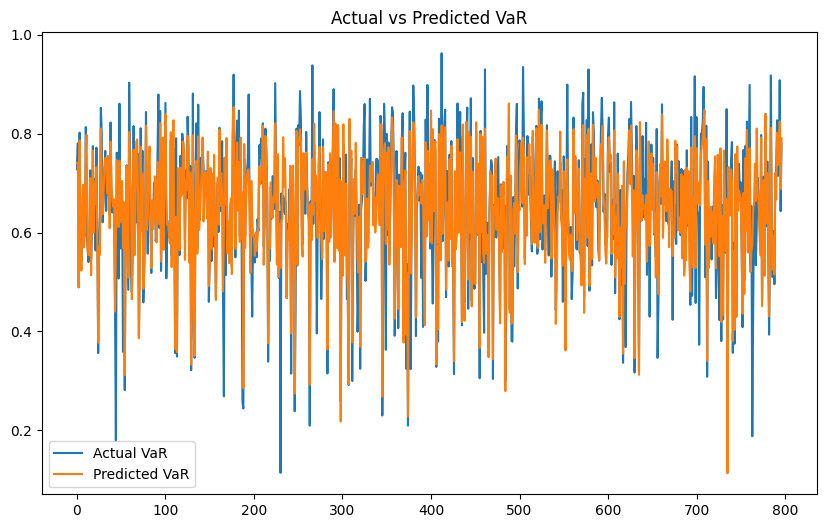

In [317]:
# Plot Actual vs Predicted Volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y1_test, label='Actual VaR')
plt.plot(y1_pred, label='Predicted VaR')
plt.title('Actual vs Predicted VaR')
plt.legend()
plt.show()

In [276]:
accuracy = np.mean(np.abs((y1_pred - y1_test) / y1_test) < 0.1) * 100
print(f"Accuracy: {accuracy}%")

Accuracy: 31.624237062132305%


In [277]:
# Calculate Mean Squared Error (MSE) for model evaluation
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y1_test, y1_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00941454318623403


In [318]:
# Calculate Mean Squared Error (MSE) for model evaluation
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y1_test, y1_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.004787120916291027


5          Normal
6          Normal
7          Normal
8          Normal
9          Normal
          ...    
3995       Normal
3996       Normal
3997    High Risk
3998    High Risk
3999    High Risk
Name: Risk_Level, Length: 3995, dtype: object

High-Risk Periods:
      timestamp  volatility
14   2024-10-26    0.030742
15   2024-10-27    0.028455
16   2024-10-28    0.031247
17   2024-10-29    0.031366
22   2024-11-03    0.029065
...         ...         ...
3985 2035-09-10    0.030773
3987 2035-09-12    0.029470
3997 2035-09-22    0.029116
3998 2035-09-23    0.029122
3999 2035-09-24    0.030961

[649 rows x 2 columns]

Low-Risk Periods:
      timestamp  volatility
21   2024-11-02    0.010422
28   2024-11-09    0.006396
29   2024-11-10    0.006371
30   2024-11-11    0.006404
47   2024-11-28    0.012346
...         ...         ...
3979 2035-09-04    0.010722
3991 2035-09-16    0.009144
3992 2035-09-17    0.009334
3993 2035-09-18    0.008760
3994 2035-09-19    0.009836

[655 rows x 2 column

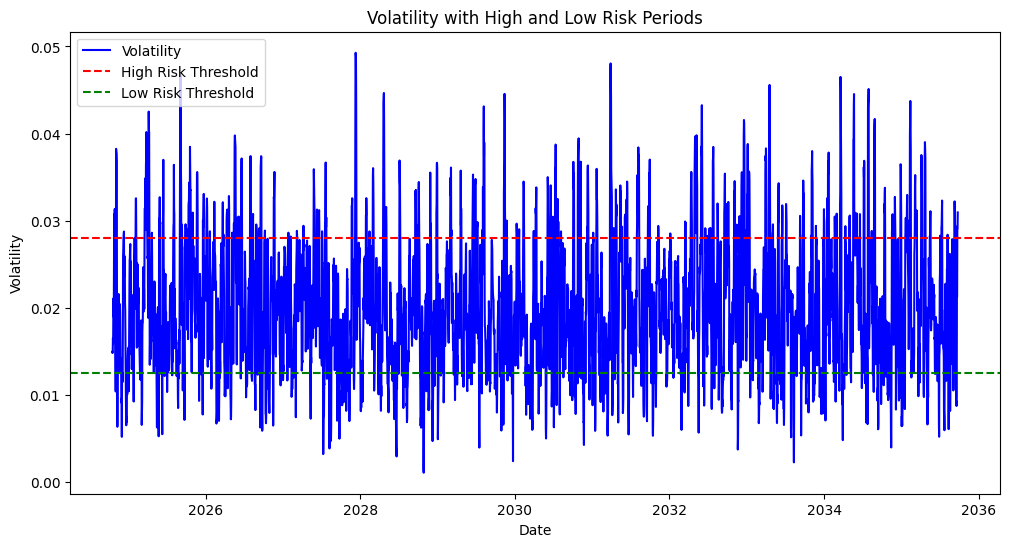

In [343]:
# Assuming your data is already loaded in 'data' with a 'volatility' column
# Example: Volatility is the 5-day rolling standard deviation of returns

# Step 1: Calculate the threshold for high and low risk
mean_volatility = data['volatility'].mean()
std_volatility = data['volatility'].std()

# High-risk threshold: 1 standard deviation above the mean
high_risk_threshold = mean_volatility + std_volatility

# Low-risk threshold: 1 standard deviation below the mean
low_risk_threshold = mean_volatility - std_volatility

# Step 2: Create new columns to mark high-risk and low-risk periods
data['Risk_Level'] = np.where(data['volatility'] > high_risk_threshold, 'High Risk', 
                              np.where(data['volatility'] < low_risk_threshold, 'Low Risk', 'Normal'))

print(data['Risk_Level'])

# Step 3: Filter and print high-risk and low-risk periods
high_risk_periods = data[data['Risk_Level'] == 'High Risk']
low_risk_periods = data[data['Risk_Level'] == 'Low Risk']

print("\nHigh-Risk Periods:")
print(high_risk_periods[['timestamp', 'volatility']])

print("\nLow-Risk Periods:")
print(low_risk_periods[['timestamp', 'volatility']])



# Step 4: Visualize the volatility and mark high/low-risk periods
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['volatility'], label='Volatility', color='blue')

# Highlight high-risk and low-risk periods
plt.axhline(high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold')
plt.axhline(low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility with High and Low Risk Periods')
plt.legend()
plt.show()

High-Risk VaR Periods:
      timestamp   returns    VaR_95
7    2024-10-19 -0.019638 -0.019178
14   2024-10-26 -0.035177 -0.031186
20   2024-11-01 -0.009559 -0.009271
21   2024-11-02 -0.016537 -0.015142
23   2024-11-04 -0.046875 -0.040807
...         ...       ...       ...
3972 2035-08-28 -0.032136 -0.030830
3980 2035-09-05 -0.021174 -0.020104
3983 2035-09-08 -0.029440 -0.027787
3992 2035-09-17 -0.005329 -0.004963
3995 2035-09-20 -0.038677 -0.032007

[712 rows x 3 columns]

Low-Risk VaR Periods:
      timestamp   returns    VaR_95
5    2024-10-17  0.002594 -0.014306
6    2024-10-18  0.010152 -0.013354
8    2024-10-20  0.017497 -0.019178
10   2024-10-22  0.025609 -0.018631
13   2024-10-25  0.040406 -0.015098
...         ...       ...       ...
3990 2035-09-15  0.016644 -0.023692
3991 2035-09-16  0.001435 -0.002513
3993 2035-09-18  0.005587 -0.004963
3994 2035-09-19  0.017445 -0.003976
3997 2035-09-22  0.036859 -0.033840

[2005 rows x 3 columns]


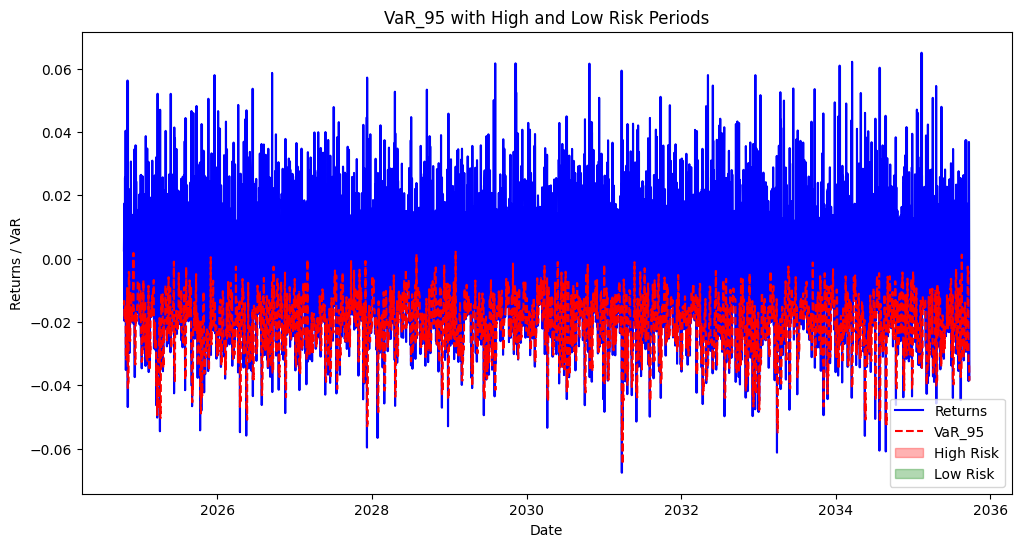

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data already has 'VaR_95' and 'returns' columns

# Step 1: Classify risk levels based on VaR breaches
# High-Risk: Returns are lower than the VaR_95 prediction (unexpected loss)
data['Risk_Level_VaR'] = np.where(data['returns'] < data['VaR_95'], 'High Risk', 'Normal')

# Step 2: Identify low-risk periods
# Low Risk: Returns are positive (indicating market gains)
data['Risk_Level_VaR'] = np.where(data['returns'] > 0, 'Low Risk', data['Risk_Level_VaR'])

# Step 3: Filter and print high-risk and low-risk periods
high_risk_var_periods = data[data['Risk_Level_VaR'] == 'High Risk']
low_risk_var_periods = data[data['Risk_Level_VaR'] == 'Low Risk']

print("High-Risk VaR Periods:")
print(high_risk_var_periods[['timestamp', 'returns', 'VaR_95']])

print("\nLow-Risk VaR Periods:")
print(low_risk_var_periods[['timestamp', 'returns', 'VaR_95']])

# Step 4: Visualize VaR breaches along with returns
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['returns'], label='Returns', color='blue')
plt.plot(data['timestamp'], data['VaR_95'], label='VaR_95', color='red', linestyle='--')

# Highlight high and low-risk periods
plt.fill_between(data['timestamp'], data['VaR_95'], data['returns'], 
                 where=(data['returns'] < data['VaR_95']), color='red', alpha=0.3, label='High Risk')

plt.fill_between(data['timestamp'], 0, data['returns'], 
                 where=(data['returns'] > 0), color='green', alpha=0.3, label='Low Risk')

plt.xlabel('Date')
plt.ylabel('Returns / VaR')
plt.title('VaR_95 with High and Low Risk Periods')
plt.legend()
plt.show()


High-Risk Cluster Summary:
     High_Risk_Cluster_ID start_date   end_date  cluster_size  duration
0                       2 2024-10-19 2024-10-19             1         1
1                       4 2024-10-26 2024-10-26             1         1
2                       6 2024-11-01 2024-11-02             2         2
3                       8 2024-11-04 2024-11-04             1         1
4                      10 2024-11-12 2024-11-12             1         1
..                    ...        ...        ...           ...       ...
668                  1338 2035-08-28 2035-08-28             1         1
669                  1340 2035-09-05 2035-09-05             1         1
670                  1342 2035-09-08 2035-09-08             1         1
671                  1344 2035-09-17 2035-09-17             1         1
672                  1346 2035-09-20 2035-09-20             1         1

[673 rows x 5 columns]

Monthly Risk Distribution:
Risk_Level_VaR  High Risk  Low Risk  Normal
Year Month   

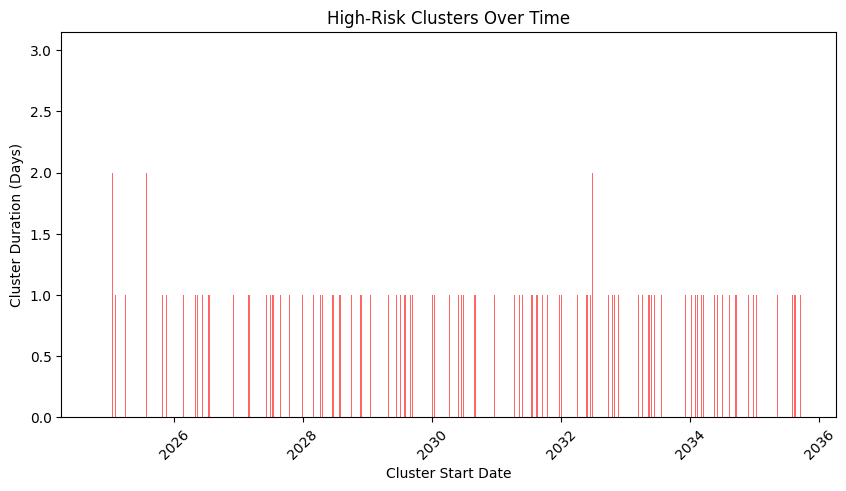

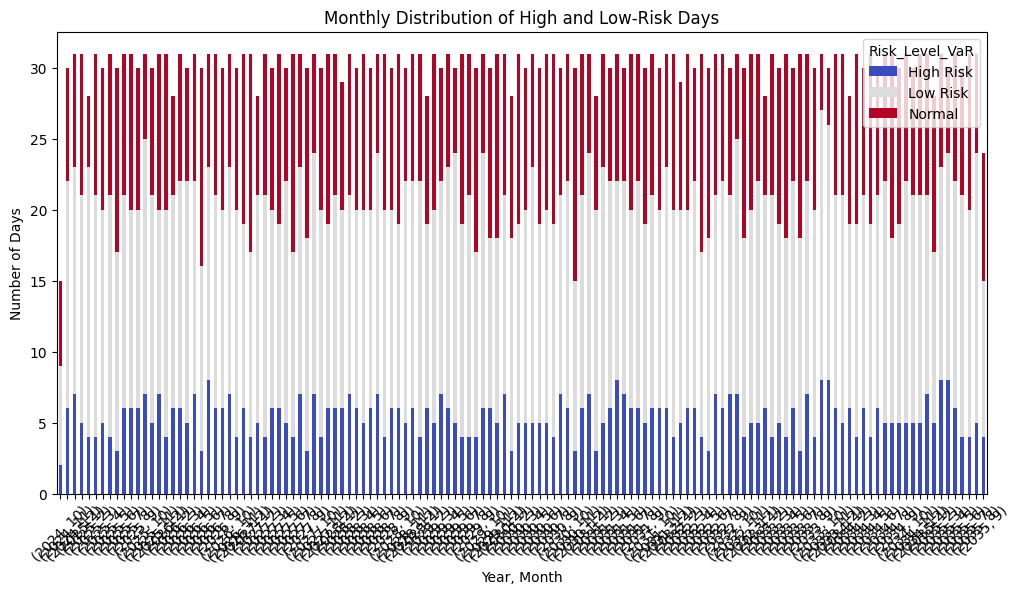

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'timestamp' column is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Step 1: Detect consecutive high-risk periods (clustering)
data['High_Risk_Cluster'] = (data['Risk_Level_VaR'] == 'High Risk').astype(int)
data['High_Risk_Cluster_ID'] = data['High_Risk_Cluster'].diff().ne(0).cumsum()  # Group consecutive high-risk days

# Filter only high-risk clusters
high_risk_clusters = data[data['Risk_Level_VaR'] == 'High Risk'].groupby('High_Risk_Cluster_ID')

# Calculate size and duration of each high-risk cluster
cluster_info = high_risk_clusters.agg(
    start_date=('timestamp', 'min'),
    end_date=('timestamp', 'max'),
    cluster_size=('timestamp', 'count')
).reset_index()

# Calculate the duration of each high-risk cluster in days
cluster_info['duration'] = (cluster_info['end_date'] - cluster_info['start_date']).dt.days + 1

print("High-Risk Cluster Summary:")
print(cluster_info)

# Step 2: Frequency analysis of high and low-risk periods over time
# Add year and month columns for grouping
data['Year'] = data['timestamp'].dt.year
data['Month'] = data['timestamp'].dt.month

# Calculate the number of high and low-risk days per month
risk_distribution = data.groupby(['Year', 'Month', 'Risk_Level_VaR']).size().unstack(fill_value=0)

print("\nMonthly Risk Distribution:")
print(risk_distribution)

# Step 3: Visualize high-risk clusters and their durations
plt.figure(figsize=(10, 5))
plt.bar(cluster_info['start_date'], cluster_info['duration'], color='red', alpha=0.6)
plt.xlabel('Cluster Start Date')
plt.ylabel('Cluster Duration (Days)')
plt.title('High-Risk Clusters Over Time')
plt.xticks(rotation=45)
plt.show()

# Step 4: Plot monthly distribution of high and low-risk days
risk_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Monthly Distribution of High and Low-Risk Days')
plt.xlabel('Year, Month')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)
plt.show()


# Conclusion: Market Risk Prediction Using Synthetic Data


In this project, market risk was predicted by leveraging synthetic time series data with key financial variables such as open, high, low, close prices, and volume. A hybrid CNN + LSTM model was built to predict volatility and Value at Risk (VaR), both of which are critical metrics for market risk assessment. Below is a summary of the key steps, outcomes, and insights derived from the analysis:

Model and Predictions
CNN + LSTM Model:

The hybrid model captured both local patterns (via CNN) and long-term dependencies (via LSTM) in time-series data.
The model was trained to predict volatility (a measure of variability) and VaR at 95% confidence level (potential financial loss).
Mean Squared Error (MSE):

The model's performance yielded MSE of 0.004 for both volatility and VaR predictions, indicating a reasonable level of prediction accuracy.
Risk Analysis and Interpretation
Volatility Prediction:

High volatility indicates a higher level of market uncertainty and the potential for large price swings, leading to increased market risk.
The model helped identify periods of high and low volatility, enabling the detection of periods when markets were more likely to experience instability.
VaR_95 Prediction:

VaR measures the maximum expected loss with 95% confidence over a specified period.
Periods where actual returns breached VaR_95 were identified as high-risk periods—indicative of unexpected losses beyond the model’s expectations.
Low-risk periods, marked by positive returns, were also identified, suggesting favorable market conditions.
Cluster and Pattern Detection
The analysis revealed clusters of consecutive high-risk periods, showing that risk events often occur in streaks rather than isolated incidents.
Monthly distribution of high and low-risk periods highlighted patterns, such as certain months being more prone to high risk, which could support seasonal risk adjustments.
Risk Mitigation Strategies
Risk management teams can leverage these insights to tighten risk limits during high-risk periods (e.g., imposing stricter trading limits or increasing capital buffers).
Proactive measures can be taken during identified low-risk periods to capitalize on favorable market conditions.
Conclusion and Key Takeaways
This project successfully demonstrated how synthetic financial data and advanced machine learning techniques can be applied to predict market risk. The use of volatility and VaR predictions provided a clear framework for identifying high-risk and low-risk periods in the market. Furthermore, clustering analysis of high-risk events enabled the identification of patterns, supporting early warning systems for market instability.

The overall framework and findings can be utilized to enhance risk management strategies and improve decision-making processes by anticipating periods of heightened market risk. This approach shows the potential of synthetic data in financial forecasting, especially when historical data is limited or privacy concerns restrict access to real data.

Refer this pages to get insights about the code...